## 🛠️ LangGraph Evaluator-Optimizer PoC: Self-Correcting Code Refactorer

This project is a Proof of Concept (PoC) implementing the **Evaluator-Optimizer** workflow using **LangGraph**.
It simulates a code review process between a "Junior Developer" (Generator) and a "Strict Senior Tech Lead" (Evaluator).

### 🎯 Objective
To build an agentic workflow that autonomously improves Python code quality by enforcing strict standards (e.g., Type Hints, Vectorization, Logging) through an iterative feedback loop.

### 🔄 Workflow Architecture
1.  **Generator Node:** Refactors "dirty" code into production-ready Python code.
2.  **Evaluator Node (LLM-as-a-Judge):** Scores the code (0-10) and provides specific critiques based on modern Python idioms.
3.  **Decision Gate:**
    * **Pass:** Score $\ge$ 9/10.
    * **Retry:** Score < 9 (Loops back to Generator with critique).

### 🧰 Tech Stack
* **Framework:** LangGraph, LangChain
* **Model:** OpenAI GPT-4o
* **Key Concept:** Reflection / Self-Correction / Human-in-the-loop logic

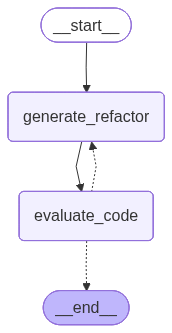

In [1]:
# evaluator_optimizer.ipynb
from typing import TypedDict, List, Optional
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field

# 모델 초기화
llm = init_chat_model("openai:gpt-4o-2024-08-06")

# --- State & Schemas ---

class State(TypedDict):
    original_code: str
    generated_code: str
    critique: Optional[str]
    score: Optional[int]
    iteration: int

class EvaluationResult(BaseModel):
    readability_score: int = Field(description="Score for naming, indentation, and clarity (0-10)")
    modern_python_score: int = Field(description="Score for using type hints, pathlib, vectorization (0-10)")
    total_score: int = Field(description="Average of sub-scores (0-10)")
    critique: str = Field(description="Constructive feedback focusing on 'Why' improvement is needed")

# --- Prompts (The Soul of the Agent) ---

GENERATOR_SYSTEM_PROMPT = """
You are a Senior Python Tech Lead. Refactor the given code to be production-ready.
Target Audience: Junior developers learning best practices.

[REFACTORING RULES]
1. **Guard Clauses:** Avoid nested `if/else`. Return early to keep indentation flat.
2. **Type Hints & Docstrings:** MANDATORY. Use `typing` module and Google-style docstrings.
3. **Data over Logic:** Replace complex `if-elif` chains with Dictionary Mappings.
4. **Modern Syntax:** - Use `pathlib` instead of `os.path`.
   - Use `f-strings` instead of `.format()`.
   - Use `df.loc` and vectorization for Pandas (No `iterrows`).
5. **Naming:** Variables must be descriptive (e.g., `user_input` instead of `x`).

If you have received critique, address it specifically.
"""

EVALUATOR_SYSTEM_PROMPT = """
You are a Strict Code Reviewer. Evaluate the code based on "Modern Python Best Practices".
Do not be generous. The goal is to educate.

[CHECKLIST]
1. **Readability:** Are variables named clearly? Are Guard Clauses used to reduce nesting?
2. **Safety:** Are Type Hints present and correct? Are magic numbers extracted to constants?
3. **Efficiency:** Is `df.loc` or vectorization used? Are loops avoided where possible?

[OUTPUT FORMAT]
- Provide specific scores.
- In the critique, explain *WHY* the change is needed (educational value).
- If the score is below 9, list 2-3 specific actionable items to fix.
"""

# --- Nodes ---

def generate_refactor(state: State):
    iteration = state["iteration"]
    
    user_content = f"Original Code:\n{state['original_code']}"
    if iteration > 0:
        user_content += f"\n\nPrevious Critique to Fix:\n{state['critique']}\n\nCurrent Draft:\n{state['generated_code']}"

    messages = [
        {"role": "system", "content": GENERATOR_SYSTEM_PROMPT},
        {"role": "user", "content": user_content}
    ]
    
    response = llm.invoke(messages)
    
    return {
        "generated_code": response.content,
        "iteration": iteration + 1
    }

def evaluate_code(state: State):
    structured_llm = llm.with_structured_output(EvaluationResult)
    
    messages = [
        {"role": "system", "content": EVALUATOR_SYSTEM_PROMPT},
        {"role": "user", "content": f"Code to Review:\n{state['generated_code']}"}
    ]
    
    response = structured_llm.invoke(messages)
    
    return {
        "score": response.total_score,
        "critique": response.critique
    }

# --- Gate ---

def decision_gate(state: State):
    score = state.get("score")
    iteration = state.get("iteration")
    
    print(f"\n--- Iteration {iteration} ---")
    print(f"Score: {score}/10")
    
    if score >= 9:
        print("✅ Code Accepted!")
        return END
    
    if iteration >= 3:
        print("⚠️ Max retries reached. Returning best effort.")
        return END
    
    print(f"🔄 Requesting changes: {state['critique'][:100]}...")
    return "generate_refactor"

# --- Graph Assembly ---

workflow = StateGraph(State)
workflow.add_node("generate_refactor", generate_refactor)
workflow.add_node("evaluate_code", evaluate_code)

workflow.add_edge(START, "generate_refactor")
workflow.add_edge("generate_refactor", "evaluate_code")
workflow.add_conditional_edges(
    "evaluate_code",
    decision_gate,
    {"generate_refactor": "generate_refactor", END: END}
)

app = workflow.compile()

app

In [ ]:
test_input_code = """
def decision_gate(state):
    score = state.get("score")
    iteration = state.get("iteration")
    
    print(f"Checking score: {score}")
    
    if score >= 9:
        print("Success")
        return "end"
    
    if iteration >= 3:
        print("Too many tries")
        return "end"
    
    print("Try again")
    return "generate_refactor"
"""

print(f"\n🚀 [Start] Evaluating 'The Pivot' Logic with gpt-4o...\n")

inputs = {"original_code": test_input_code, "iteration": 0}

final_generated_code = ""

for event in app.stream(inputs):
    for key, value in event.items():
        print(f"\n--- Node: {key} ---")
        
        if key == "generate_refactor":
            print("✍️  Generating Refactored Code...")
            final_generated_code = value['generated_code']
            
        elif key == "evaluate_code":
            print(f"📊 Score: {value['score']}/10")
            print(f"📝 Critique: {value['critique']}")

print("\n" + "="*50)
print("FINAL RESULT (Refactored Code)")
print("="*50)

if final_generated_code:
    print(final_generated_code)
else:
    print("Error: No code was generated.")


🚀 [Start] Evaluating 'The Pivot' Logic with gpt-4o...


--- Node: generate_refactor ---
✍️  Generating Refactored Code...

--- Iteration 1 ---
Score: 8/10
🔄 Requesting changes: The code is generally well-structured and follows some modern Python practices effectively. However,...

--- Node: evaluate_code ---
📊 Score: 8/10
📝 Critique: The code is generally well-structured and follows some modern Python practices effectively. However, there are a few areas that can be improved to align more closely with modern standards and best practices.

1. **Magic Numbers**: While the code uses clear guard clauses and meaningful naming, it would be beneficial to extract the magic numbers (e.g., `9`, `3`) into named constants to enhance clarity and maintainability. This allows for easier adjustments in the future if these values ever need to change and improves readability by giving context-specific names to the numeric values.

2. **Efficiency - Vectorization**: While the code is not directly relate